## Group No 193

## Group Member Names:
1. Emily Ganguly (2023AC05471)
2.
3.
4.

## Journal used for the implemetation
Journal title: Predicting stock market index using LSTM

Authors:Hum Nath Bhandari, Binod Rimal, Nawa Raj Pokhrel, Ramchandra Rimal, Keshab R. Dahal, Rajendra K.C. Khatri

Journal Name: Elsevier

Year: 2022

# 1. Import the required libraries

In [18]:
##---------Type the code below this line------------------##
!pip install yfinance
!pip install fredapi
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adagrad
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 2. Data Acquisition

For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [5]:
##---------Type the code below this line------------------##
# Tickers for Yahoo Finance data
tickers = {
    'CBOE_VIX': '^VIX',
    'USD_Index': 'DX-Y.NYB'
}

start_date = '2006-01-01'
end_date = '2020-12-31'

data = {}
for key, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)[['Open', 'Close']]

    # Ensure correct column renaming
    df.columns = [f"{key}_{col}" for col in df.columns.get_level_values(0)]  # Fix multi-index issue

    data[key] = df

# Fetching data from FRED
api_key = 'a2c4f309bff42cdc07990981c5a6c237'
fred = Fred(api_key=api_key)

series = {
    'Interest_Rate': 'FEDFUNDS',
    'Unemployment_Rate': 'UNRATE',
    'Consumer_Sentiment_Index': 'UMCSENT'
}

fred_data = {}
for key, series_id in series.items():
    fred_series = fred.get_series(series_id, start_date, end_date)
    fred_data[key] = pd.DataFrame(fred_series, columns=[key])  # Converting to DataFrame

# Extracting dates from Yahoo Finance Data
dates = data['CBOE_VIX'].index

# Aligning FRED data with Yahoo Finance data
for key in fred_data:
    fred_data[key] = fred_data[key].reindex(dates).ffill()

# Merging all data into one DataFrame
combined_df = data['CBOE_VIX'].join([data['USD_Index']] + list(fred_data.values()))

# Filling missing values
combined_df = combined_df.ffill()
combined_df = combined_df.ffill().bfill()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)
scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns, index=combined_df.index)

# Function to calculate MACD
def calculate_macd(df, column, prefix):
    df[f'{prefix}_EMA_fast'] = df[column].ewm(span=12, adjust=False).mean()
    df[f'{prefix}_EMA_slow'] = df[column].ewm(span=26, adjust=False).mean()
    df[f'{prefix}_MACD'] = df[f'{prefix}_EMA_fast'] - df[f'{prefix}_EMA_slow']
    df[f'{prefix}_MACD_signal'] = df[f'{prefix}_MACD'].ewm(span=9, adjust=False).mean()
    return df

# Function to calculate RSI
def calculate_rsi(df, column, prefix, period=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df[f'{prefix}_RSI'] = 100 - (100 / (1 + rs))
    df[f'{prefix}_RSI'] = df[f'{prefix}_RSI'].ffill().bfill()
    return df

# Apply indicators
scaled_df = calculate_macd(scaled_df, 'CBOE_VIX_Close', 'VIX')
scaled_df = calculate_macd(scaled_df, 'USD_Index_Close', 'USD')
scaled_df = calculate_rsi(scaled_df, 'CBOE_VIX_Close', 'VIX')
scaled_df = calculate_rsi(scaled_df, 'USD_Index_Close', 'USD')

# Save to CSV
scaled_df.to_csv('financial_data_with_indicators.csv')

print("Final Data Sample:")
print(scaled_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Final Data Sample:
            CBOE_VIX_Open  CBOE_VIX_Close  USD_Index_Open  USD_Index_Close  \
Date                                                                         
2006-01-03       0.043974        0.027192        0.608205         0.579161   
2006-01-04       0.029995        0.030320        0.576261         0.557259   
2006-01-05       0.032845        0.029504        0.561854         0.563204   
2006-01-06       0.030130        0.025289        0.564359         0.548185   
2006-01-09       0.031759        0.027056        0.552145         0.560701   

            Interest_Rate  Unemployment_Rate  Consumer_Sentiment_Index  \
Date                                                                     
2006-01-03       0.852207           0.107143                  0.677632   
2006-01-04       0.852207           0.107143                  0.677632   
2006-01-05       0.852207           0.107143                  0.677632   
2006-01-06       0.852207           0.107143                  0.

# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [8]:
##---------Type the code below this line------------------##
# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 1])  # Predicting CBOE_VIX_Close
    return np.array(sequences), np.array(labels)

sequence_length = 30  # Using 30-day sequences
X, y = create_sequences(scaled_data, sequence_length)

## Split the data into training set and testing set
##---------Type the code below this line------------------##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Identify the target variables.
##---------Type the code below this line------------------##
print("Target variable: CBOE_VIX_Close. The first 5 values are - ")
print(y_train[:5])

Target variable: CBOE_VIX_Close. The first 5 values are - 
[0.04309993 0.03181508 0.03902107 0.04445954 0.03725356]


## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [9]:
##---------Type the code below this line------------------##
# Building LSTM Model

model = Sequential([
    LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])
optimizer = Adagrad(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



# 5. Training the model


In [15]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 8.7435e-04 - val_loss: 0.0025
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 9.9859e-04 - val_loss: 0.0022
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 8.6246e-04 - val_loss: 0.0022
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 8.1689e-04 - val_loss: 0.0021
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 9.5186e-04 - val_loss: 0.0020
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 8.7039e-04 - val_loss: 0.0022
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 9.5333e-04 - val_loss: 0.0021
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 9.4415e-04 - val_loss: 0.0020
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 8.2762e-04 - val_loss: 0.0020
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 9.3372e-04 - val_loss: 0.002

# 6. Test the model


In [11]:
##---------Type the code below this line------------------##

# Making predictions
y_pred = model.predict(X_test)

# Computing evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R^2 Score: {r2}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
RMSE: 0.04632014796704462
MAPE: 0.1725285076107788
R^2 Score: 0.8848612709979264


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


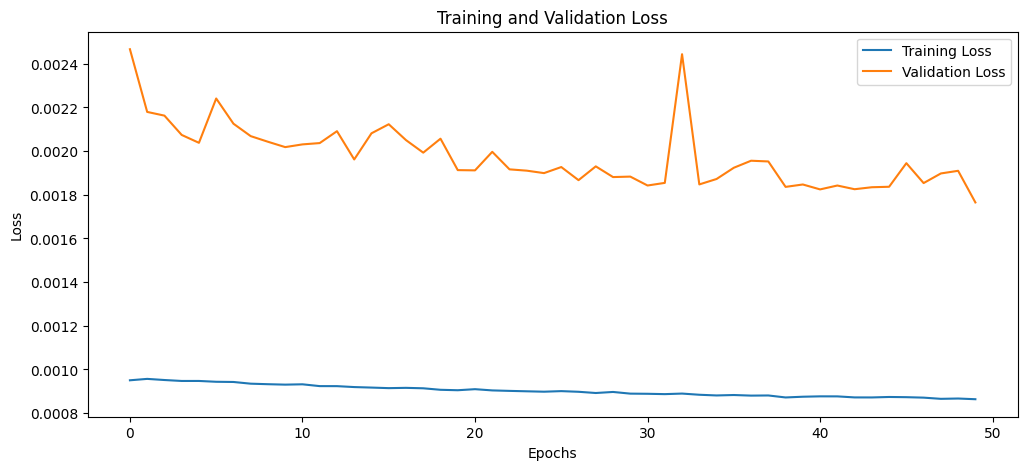

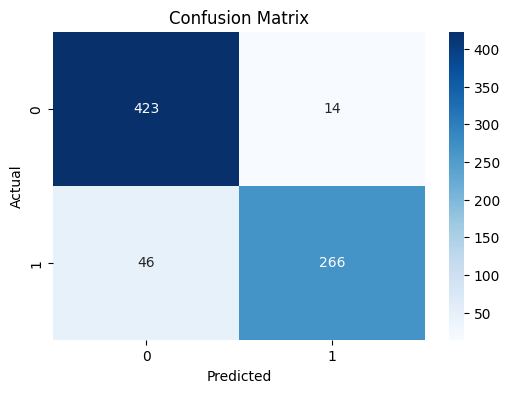

Accuracy: 0.9198931909212283
Precision: 0.95
Recall: 0.8525641025641025
F1 Score: 0.8986486486486487


In [22]:
##---------Type the code below this line------------------##
# Ploting Training & Validation Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convert predictions to binary (1 if above mean, 0 otherwise)
threshold = np.mean(y_train)
y_test_bin = (y_test > threshold).astype(int)
y_pred_bin = (y_pred > threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Metrics
accuracy = accuracy_score(y_test_bin, y_pred_bin)
precision = precision_score(y_test_bin, y_pred_bin)
recall = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck